# Imports

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt 

from lifelines.datasets import load_rossi
from sksurv.metrics import concordance_index_censored

from utils.data import init_gamma, init_beta
from utils.model import Model
from utils.client import Client 
from utils.splines import bspline_design_matrix

2025-06-05 14:15:49.504212: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Configs

In [17]:
EPS = 1e-5
N_ITER_GLOBAL = 4000

N_SAMPLES = 500

np.random.seed(42)
SEEDS = np.random.choice(range(10000), size=5)
print(SEEDS)

rho = 1

[7270  860 5390 5191 5734]


# Data

In [3]:
event_col = "event"
duration_col = "duration"

In [4]:
from sklearn.datasets import make_classification


def make_data(n_samples, seed):

    # Feature matrix and event time 
    X, y = make_classification(
        n_samples=N_SAMPLES, n_features=5, n_informative=2, n_redundant=2, n_repeated=0, 
        n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, 
        hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=seed
    )

    rnd = np.random.RandomState(seed=seed)
    
    # Simulate event times
    # Class 1 -> shorter survival time, Class 0 -> longer
    baseline_time = rnd.exponential(scale=10, size=y.shape[0])
    survival_time = baseline_time * (0.5 + y)  # Class 1 has shorter survival times
    
    # Simulate random censoring
    censoring_time = rnd.exponential(scale=15, size=y.shape[0])
    duration = np.minimum(survival_time, censoring_time)
    event = survival_time <= censoring_time
    
    # Create DataFrame for clarity
    data = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])
    data[duration_col] = duration
    data[event_col] = event.astype(int)

    return data, X, event, duration


data, X, event, duration = make_data(N_SAMPLES, SEEDS[0])
data.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,duration,event
0,-0.283269,-1.503986,0.584319,1.110368,0.752608,7.851225,1
1,0.430450,-0.982862,-0.078302,0.474867,0.481233,5.382143,0
2,-1.700872,-1.174093,1.562304,-3.204284,0.613009,1.009546,0
3,-0.451474,0.769189,0.146950,-0.108875,-0.374640,1.148273,1
4,0.278403,-0.567891,-0.067439,-1.028853,0.277542,4.765891,1


In [5]:
from sksurv.util import Surv
# Create structured arrays
y = Surv.from_arrays(event=event, time=duration)

# Pre-processing 

In [6]:
from utils.data import feature_scaling
# Scale features with Z-score transfrom 
X_sc = feature_scaling(X)

In [7]:
from utils.data import init_knots
# Set knot locations 
knots = init_knots(duration, event, n_knots=5)
min(knots), max(knots)

(-3.317493653263726, 3.6080090924908443)

# Fit reference model 

Converged after 3398 iterations


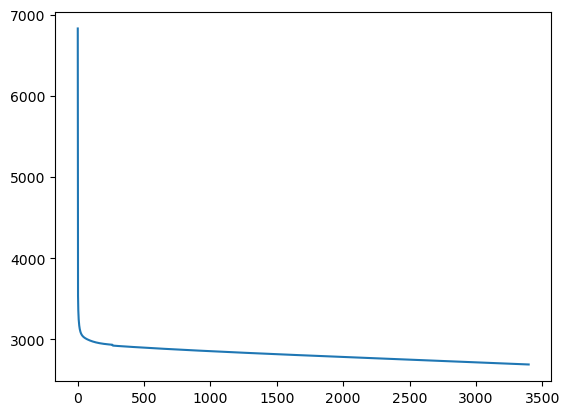

In [8]:
beta = init_beta(X_sc, y)
gamma = np.ones((1, 7))

ref_model = Model(epochs=N_ITER_GLOBAL, knots=knots, learning_rate=0.001, l2_lambda=1, rho=rho)
ref_model.set_params({"beta": beta, "gamma": gamma}) 
ref_model.fit(X_sc, y, tol=EPS)

plt.figure()
plt.plot(ref_model.losses)

In [9]:
np.save("../data/price-of-federation-fedavg/rossi_gradients_loss_ref.npy", ref_model.losses)

In [10]:
np.save("../data/price-of-federation-fedavg/rossi_gradients_beta_global_ref.npy", ref_model.beta)
ref_model.beta

array([[ 0.00374707, -0.0182598 , -0.00010591,  0.00619029,  0.01755206]],
      dtype=float32)

In [11]:
np.save("../data/price-of-federation-fedavg/rossi_gradients_gamma_global_ref.npy", ref_model.gamma)
ref_model.gamma

array([[0.98480004, 0.98652375, 0.98801947, 0.9970567 , 1.0073932 ,
        1.0085052 , 1.0144321 ]], dtype=float32)

# Number of clients 

In [12]:
# TODO: 
# - plot number of server iterations as function of number of local iterations 
# - plot parameter accuracy as function of number of local iterations 

In [13]:
def has_converged(params, params_other):
    return np.linalg.norm(params_other - params) <= EPS 

In [14]:
def cosine_annealing_lr(epoch, max_epochs, initial_lr=0.1, min_lr=0.0001):
    """
    Cosine annealing learning rate scheduler.
    """
    cos_inner = np.pi * epoch / max_epochs
    lr = min_lr + 0.5 * (initial_lr - min_lr) * (1 + np.cos(cos_inner))
    return lr

In [21]:
#for seed in SEEDS:
for seed in [SEEDS[0]]:
    print("*" * 20)
    print("SEED:", seed)
    print("*" * 20)
    for N_SPLITS in [1]: #, 2, 4, 6, 8, 10]:
        data_idx = np.arange(data.shape[0])
        np.random.seed(seed)
        np.random.shuffle(data_idx)
        DATA_SPLIT_IDX = np.array_split(data_idx, N_SPLITS)
        
        participants = []
        for idx in range(N_SPLITS):
            client = Client(data.iloc[DATA_SPLIT_IDX[idx]], n_knots=5, n_epochs=10, event_col=event_col, duration_col=duration_col, rho=rho)
            client.preprocess_data(train_test_split=False)
            client.init_model(local_knots=False, knots=knots, learning_rate=0.001)
            participants.append(client)        
        
        beta_global = beta.copy()
        gamma_global = gamma.copy()
        beta_global_prev = beta.copy() #np.zeros_like(beta_global)
        gamma_global_prev = gamma.copy() #np.zeros_like(gamma_global)
        
        losses = []
        for i in range(N_ITER_GLOBAL):
            update_beta, update_gamma, losses_i = [], [], []
            for client in participants:
                client.fit_model(beta_global, gamma_global, tol=EPS)
                
                # Gather parameter updates
                update_beta.append(client.beta)
                update_gamma.append(client.gamma)
                
                losses_i.append(client.model_loss())

            losses.append(np.mean(losses_i))

            # Update learning rate 
            #alpha = cosine_annealing_lr(i, N_ITER_GLOBAL)
            
            # Global update
            alpha = 0.01
            beta_global = alpha * np.mean(update_beta, axis=0) + (1 - alpha) * beta_global_prev
            gamma_global = alpha * np.mean(update_gamma, axis=0) + (1 - alpha) * gamma_global_prev
                    
            if has_converged(beta_global, beta_global_prev) and has_converged(gamma_global, gamma_global_prev):
                print(f"Converged after {i} iterations")
                break 
        
            if i % (N_ITER_GLOBAL / 10) == 0:
                change_beta = np.linalg.norm(beta_global - beta_global_prev) 
                change_gamma = np.linalg.norm(gamma_global - gamma_global_prev)
                print(f"Iter {i}: {change_beta}; {change_gamma}")
        
            beta_global_prev = beta_global
            gamma_global_prev = gamma_global
        
        #plt.figure()
        #plt.plot(losses)
        
        print("-" * 20)
        print("Diff beta:", np.linalg.norm(beta_global - ref_model.beta))
        print("Diff gamma:", np.linalg.norm(gamma_global - ref_model.gamma))
        print()
        print()
        
        version = f"seed_{seed}_clients_{N_SPLITS}"
        
        np.save(f"../data/price-of-federation-fedavg/rossi_gradients_loss_{version}.npy", losses)
        np.save(f"../data/price-of-federation-fedavg/rossi_gradients_beta_global_{version}.npy", beta_global)
        np.save(f"../data/price-of-federation-fedavg/rossi_gradients_gamma_global_{version}.npy", gamma_global)

********************
SEED: 7270
********************
Iter 0: 0.020247901509548364; 0.011765269935006418
Iter 400: 0.0009425326716154814; 0.01357242465019226
Iter 800: 0.00107100629247725; 0.002151880878955126
Iter 1200: 0.0010716990800574422; 0.002181805670261383
Iter 1600: 0.0010731632355600595; 0.00217640888877213
Iter 2000: 0.0010743695311248302; 0.0021560590248554945
Iter 2400: 0.001073493855074048; 0.002162759890779853
Iter 2800: 0.0010715842945501208; 0.0021497574634850025
Iter 3200: 0.001071134116500616; 0.002141773933544755
Iter 3600: 0.001071035279892385; 0.0021654663141816854


KeyboardInterrupt: 

In [ ]:
Iter 3600: 3.9490887129897804e-05; 0.0009023800566441545
--------------------
Diff beta: 0.16242537712413352
Diff gamma: 3.7199426212626556


In [ ]:
from collections import defaultdict

results = defaultdict(list)

for N_SPLITS in [1, 2, 4, 6, 8, 10]:
    
    loss, beta, gamma = [], [], [] 
    
    for seed in SEEDS: 
        version = f"seed_{seed}_clients_{N_SPLITS}"

        loss_i = np.load(f"../data/price-of-federation-fedavg/rossi_gradients_loss_{version}.npy")
        beta_i = np.load(f"../data/price-of-federation-fedavg/rossi_gradients_beta_global_{version}.npy")
        gamma_i = np.load(f"../data/price-of-federation-fedavg/rossi_gradients_gamma_global_{version}.npy")
        
        loss.append(len(loss_i))
        beta.append(np.linalg.norm(beta_i - ref_model.beta))
        gamma.append(np.linalg.norm(gamma_i - ref_model.gamma))

        
    results["clients"].append(N_SPLITS)
    
    results["loss_avg"].append(np.mean(loss, axis=0))
    results["loss_std"].append(np.std(loss, axis=0))
    
    results["beta_avg"].append(np.mean(beta, axis=0))
    results["beta_std"].append(np.std(beta, axis=0))

    results["gamma_avg"].append(np.mean(gamma, axis=0))
    results["gamma_std"].append(np.std(gamma, axis=0))

In [ ]:
y_coords = results["loss_avg"]
x_coords = results["clients"]

plt.figure(figsize=(6, 4))
plt.errorbar(x_coords, y_coords, yerr=results["loss_std"], marker="o", linestyle="", capsize=3)
plt.ylabel("Server iterations until convergence");
plt.xlabel("Number of clients");
plt.xticks(x_coords, x_coords);

In [ ]:
x_coords, y_coords, y_err = [], [], []
for N_SPLITS in [1, 2, 4, 6, 8, 10]:
    
    data_idx = np.arange(data.shape[0])
    np.random.seed(SEEDS[2])
    np.random.shuffle(data_idx)
    DATA_SPLIT_IDX = np.array_split(data_idx, N_SPLITS)

    durations = []
    for idx in range(N_SPLITS):
        data_c = data.iloc[DATA_SPLIT_IDX[idx]]
        durations.append(np.mean(data_c["duration"]))

    x_coords.append(N_SPLITS)
    y_coords.append(np.mean(durations))
    y_err.append(np.std(durations))

# Larger variation in local data distributions as the number of clients increase 
plt.figure(figsize=(6, 4))
#plt.errorbar(x_coords, y_coords, yerr=y_err, marker="o", linestyle="-", capsize=3)
#plt.ylabel("Event time distribution");
plt.plot(x_coords, y_err, marker="o", linestyle="")
plt.ylabel("Standard deviation of event times");
plt.xlabel("Number of clients");
plt.xticks(x_coords, x_coords);

In [ ]:
y_coords = results["beta_avg"]
x_coords = results["clients"]

plt.figure(figsize=(6, 4))
plt.errorbar(x_coords, y_coords, yerr=results["beta_std"], marker="o", linestyle="", capsize=3)
plt.ylabel("Error beta");
plt.xlabel("Number of clients");
plt.xticks(x_coords, x_coords);

In [ ]:
y_coords = results["gamma_avg"]
x_coords = results["clients"]

plt.figure(figsize=(6, 4))
plt.errorbar(x_coords, y_coords, yerr=results["gamma_std"], marker="o", linestyle="", capsize=3)
plt.ylabel("Error gamma");
plt.xlabel("Number of clients");
plt.xticks(x_coords, x_coords);